# THE BATTLE OF NEIGHBORHOODS

# Introduction:

### 1.1	Background

New York City, simply called New York and abbreviated as NYC, is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles, New York City is also the most densely populated major city in the United States.

Situated on one of the world's largest natural harbors, New York City is composed of five boroughs, each of which is a county of the State of New York. The five boroughs—Brooklyn, Queens, Manhattan, the Bronx, and Staten Island—were consolidated into a single city in 1898. The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world as of 2016.

The Restaurants industry in New York has experienced steady growth over the five years to 2018, as convenient and affordable food remains popular with consumers. While the low price point of the industry's products typically places restaurants and coffee shops with a competitive advantage over other segments of the foodservices sector, rising consumer sentiment has increased competition overall. Furthermore, with the rise of fast-casual concepts rapidly gaining market share, major industry operators have had to alter their offerings to effectively compete.

Given the history mentioned this project will attempt to answer the following questions in the Problem section.

### 1.2	Problem

To find the answers to the following questions:
 
#### 1) What is the best location in New York City for Chinese Food? 
#### 2) Which areas have potential for additional Chinese Restaurants? 
#### 3) Which is the best place to stay if you prefer Chinese Food?
#### 4) List and visualize all major parts of New York City that has high ranked Chinese restaurants

### 1.3	Interested audience
The target audience for such a project is twofold. Firstly, any person who is visiting New York City can use the plots and maps from this project with an interested in Chinese food to select areas to travel to.  Secondly, an investor can use this information to determine if they want to invest in a Chinese restaurant.


# Data:

This project will need the following data that we can leverage from earlier in the capstone course:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Chinese resturants in each neighborhood of new york city.
3. GeoSpace data

# Methodology:

1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API Developer Account.
3. We will then filter out all Chinese Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
!conda install -c conda-forge geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geo

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [12]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = 'WQ2BM100D0TDQFCWCRCMGW5FQXMF513TRJRVBJACN0WIMDXP'
    CLIENT_SECRET = '3MIZONU2BLDHJKCEBVUHQ3C3WPB1YOZXI3QYT54HTQPQ4HUC'
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id from the Foursquare API.

In [13]:
def get_venue_details(venue_id):
   
    CLIENT_ID = 'WQ2BM100D0TDQFCWCRCMGW5FQXMF513TRJRVBJACN0WIMDXP'
    CLIENT_SECRET = '3MIZONU2BLDHJKCEBVUHQ3C3WPB1YOZXI3QYT54HTQPQ4HUC'
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the New York City data.

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

## The above result shows that there are 306 different Neighborhoods in New York.

Below we will create a Bar Pot to show different Neighborhoods in New York.

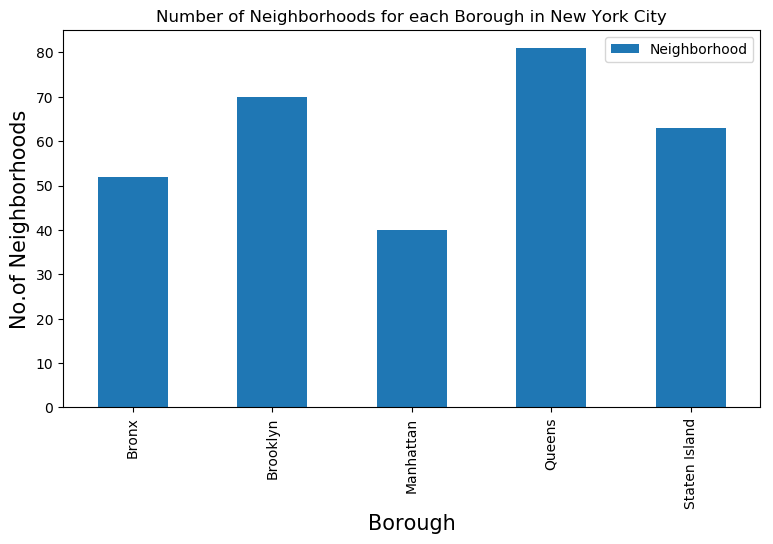

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will interact with the Foursquare API to gather Chinese resturants for each Neighborhood.

In [15]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:3
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:0
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:2
( 13 / 306 ) Chinese Resturants in City Island, Bronx:0
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:0
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

Now that we have gathered the Chinese restaurants in the city, we can begin to analyze it.

In [16]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,4da39def540ea1cdfb3b95de,Yeung Hing Chinese Restsurant
1,Bronx,Norwood,4e6aa73eaeb7c31e43294be9,Sing Fei Chinese Restaurant
2,Bronx,Norwood,4ce313fc438b224bbc6c80a3,Happy Dragon
3,Bronx,Norwood,4c3a5b280a71c9b6762844c9,Wok Wok
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant


In [17]:
chinese_rest_ny.shape

(215, 4)

### From the above result, we see that there are 215 Chinese Restaurants across New York City.

Now let create a Bar Plot to show Number of Chinese Restaurants for each Borough in New York City.

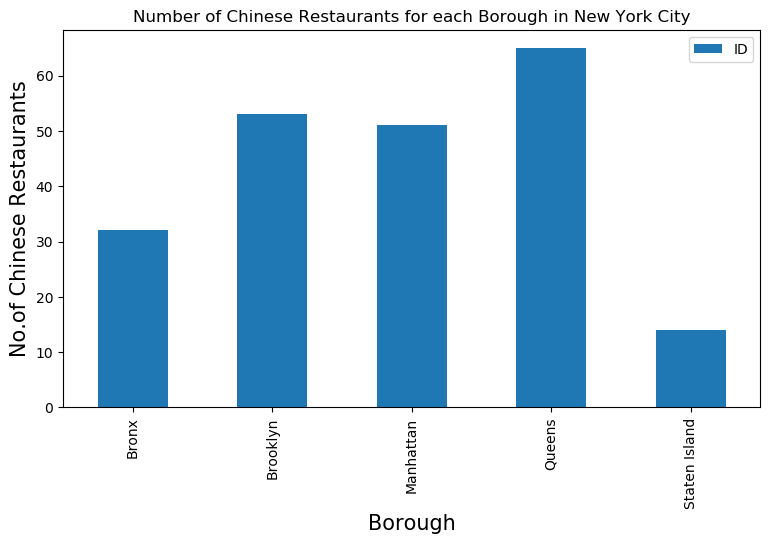

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## From the above Bar Plot, we can see that X has highest number of Chinese resturants.

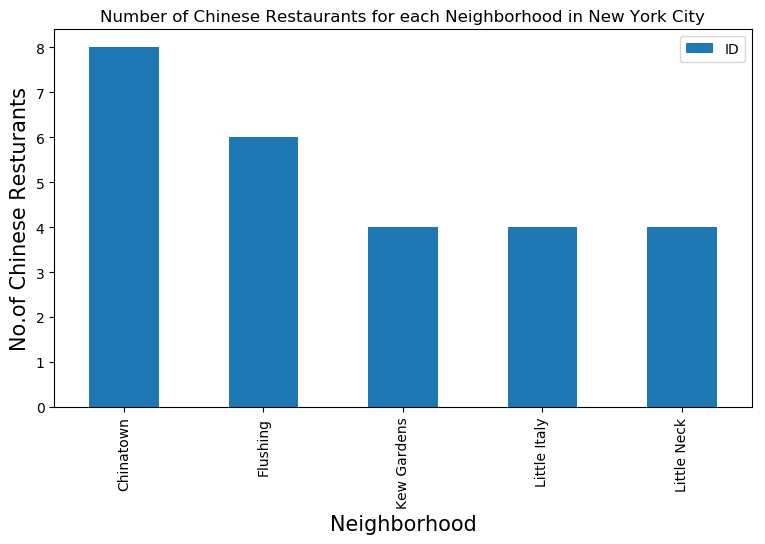

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [21]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
62,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
63,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
64,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
65,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
66,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
67,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
68,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
69,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺


### We can see that, Chinatown in Manhattan has the highest number of Chinese Resturants with a total count of 8.

Now we will get the ranking of each resturant for further analysis.

In [24]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4da39def540ea1cdfb3b95de
( 1 / 215 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6aa73eaeb7c31e43294be9
( 2 / 215 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ce313fc438b224bbc6c80a3
( 3 / 215 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c3a5b280a71c9b6762844c9
( 4 / 215 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant      9     7.8    10
( 5 / 215 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bc8f646b6c49c74d8898d91
( 6 / 215 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chines

In [25]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,0,0,0,0,0
1,Bronx,Norwood,0,0,0,0,0
2,Bronx,Norwood,0,0,0,0,0
3,Bronx,Norwood,0,0,0,0,0
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.8,10


In [26]:
chinese_rest_stats_ny.shape

(215, 7)

In [28]:
chinese_rest_ny.shape

(215, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [29]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [30]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [31]:
chinese_rest_stats_ny_csv.shape

(215, 7)

In [32]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,0,0,0,0.0,0
1,Bronx,Norwood,0,0,0,0.0,0
2,Bronx,Norwood,0,0,0,0.0,0
3,Bronx,Norwood,0,0,0,0.0,0
4,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.8,10


In [33]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
Borough         215 non-null object
Neighborhood    215 non-null object
ID              215 non-null object
Name            215 non-null object
Likes           215 non-null object
Rating          215 non-null object
Tips            215 non-null object
dtypes: object(7)
memory usage: 11.8+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [40]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [27]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Borough         151 non-null object
Neighborhood    151 non-null object
ID              151 non-null object
Name            151 non-null object
Likes           151 non-null float64
Rating          151 non-null float64
Tips            151 non-null float64
dtypes: float64(3), object(4)
memory usage: 6.0+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [36]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               8.8
Tips                                 521
Name: 91, dtype: object

In [41]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                                 9
Tips                                  10
Name: 97, dtype: object

In [42]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               8.8
Tips                                 521
Name: 91, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [43]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [32]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
12,Civic Center,9.100000
69,Tribeca,9.100000
0,Astoria,9.000000
5,Blissville,9.000000
75,West Village,8.800000
44,Midtown South,8.800000
43,Midtown,8.800000
29,Gramercy,8.733333
25,Fort Greene,8.700000
11,Chelsea,8.700000


## Above are the top neighborhoods with top average rating of Chinese resturants.

Similarly we will find the average rating of Indian Resturants for each Borough.

In [44]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [45]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.713725
1,Brooklyn,4.175472
3,Queens,3.750769
4,Staten Island,2.471429
0,Bronx,2.337500


Lets Visualize it.

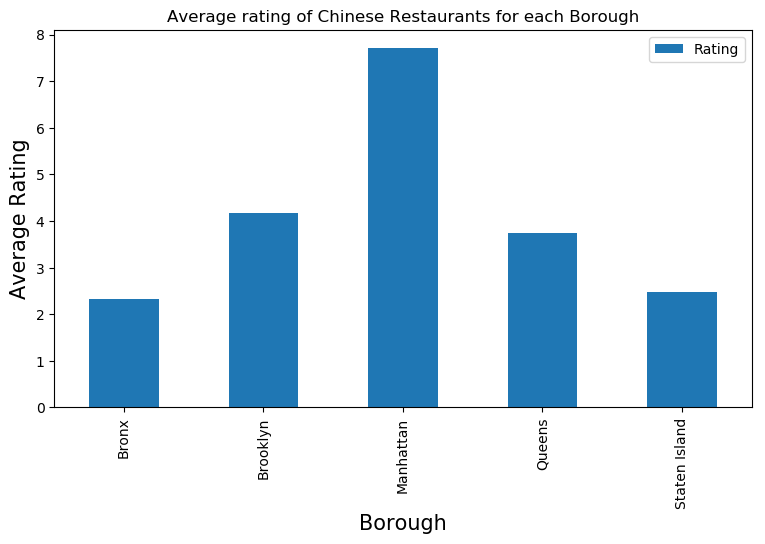

In [47]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map.

In [50]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [51]:
ny_neighborhood_stats

,Neighborhood,Average Rating
23,Chelsea,8.800000
24,Chinatown,8.425000
39,Downtown,8.233333
41,East Village,8.500000
43,Elmhurst,8.200000
59,Greenwich Village,8.300000
74,Little Italy,8.550000
84,Midtown,8.200000
85,Midtown South,8.700000
89,Murray Hill,8.650000


We will join this dataset to original new york data to get lonitude and latitude.

In [52]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [53]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [54]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.800000
1,Staten Island,Chelsea,40.594726,-74.189560,8.800000
2,Manhattan,Chinatown,40.715618,-73.994279,8.425000
3,Brooklyn,Downtown,40.690844,-73.983463,8.233333
4,Manhattan,East Village,40.727847,-73.982226,8.500000
5,Queens,Elmhurst,40.744049,-73.881656,8.200000
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.300000
7,Manhattan,Little Italy,40.719324,-73.997305,8.550000
8,Manhattan,Midtown,40.754691,-73.981669,8.200000
9,Manhattan,Midtown South,40.748510,-73.988713,8.700000


Finally, Let's show this data on a map.

In [57]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [58]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [59]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [60]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating.

# Conclusion:

## Based on the Analysis completed we can can answer the questions asked in the Questions section of the notebook based on the data that was returned during execution

## Below is a recap of the questions along with there answers:


## After collecting data from the Foursquare, filtering it for Chinese Restaurants along with retrieving specific venue details we can answer the questions we initially started with.

### 1) What is best location in New York City for Chinese Food? 

In the borough of Manhattan, the following locations are tops based on:

#### Ratings: Kings County Imperial in the Lower East Side
#### Tips: Buddakan in Chelsea
#### Likes: Buddakan in Chelsea

### 2) Which areas have potential for additional Chinese Restaurants?

Staten Island has the fewest Chinese Restaurants however, the Bronx has the lowest rated Chinese Restaurants so depending on the type of Chinese Restaurant could further research these to areas to which one is a better fit.

### 3) Which is the best place to stay if you prefer Chinese Food?

Manhattan is the best place to stay to find the best rated Chinese Food.

### 4) List and visualize all major parts of New York City that has high ranked Chinese restaurants.


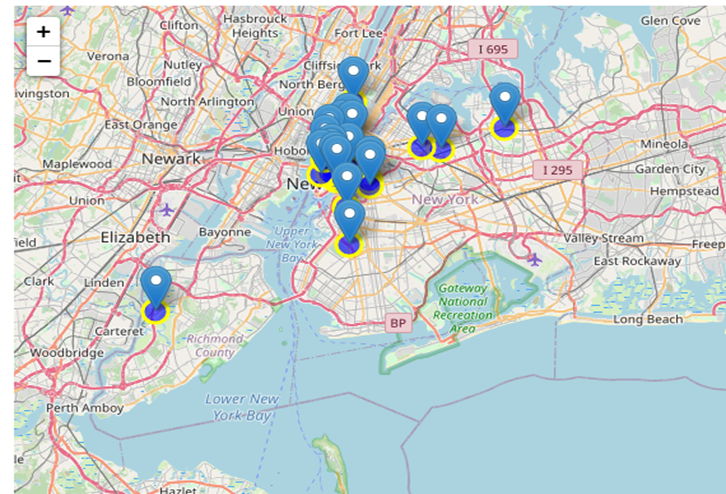